In [1]:
!pip install ipywidgets transformers[torch] datasets ipywidgets torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of ipython to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement jedi>=0.16 (from ipython) (from versions: none)
ERROR: No matching distribution found for jedi>=0.16


In [2]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Load Dataset**

In [3]:
from datasets import load_dataset
dataset = load_dataset("mdwiratathya/SLAKE-vqa-english")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/8.34M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/9.59M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4919 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1053 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1061 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 4919
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1053
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1061
    })
})

**Data Sample Visualization**

Question: Which part of the body does this image belong to?
Answer: Abdomen


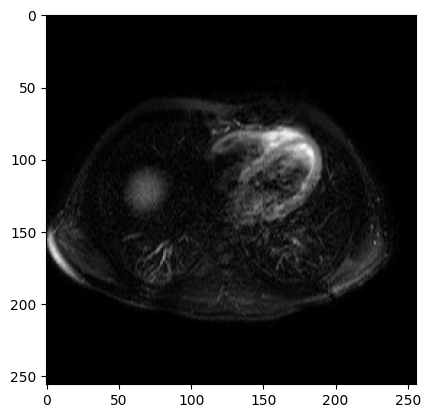

In [5]:
data_sample = dataset['train'][1]
processed_pil_image = Image.fromarray(np.array(data_sample['image'])).convert('RGB')
plt.imshow(data_sample['image'].convert('RGB'))
print("Question: {}".format(data_sample['question']))
print("Answer: {}".format(data_sample['answer']))

In [6]:
model_configuration = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

config.json: 0.00B [00:00, ?B/s]

In [7]:
class VQADataset(torch.utils.data.Dataset):

    def __init__(self, raw_data, data_segment, text_proc, img_proc, transform=None):
        self.raw_data = raw_data
        self.question_list = raw_data['question']
        self.answer_list = raw_data['answer']
        self.text_proc = text_proc
        self.img_proc = img_proc
        self.transform = transform  # Store the transform
        self.token_max_length = 32
        self.target_height = 128
        self.target_width = 128

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, index):
        current_answer = self.answer_list[index]
        current_question = self.question_list[index]
        input_image = self.raw_data[index]['image'].convert('RGB')

        # Apply augmentation only if a transform is provided
        if self.transform:
            input_image = self.transform(input_image)

        input_text = self.question_list[index]

        image_encoding = self.img_proc(input_image,
                                  do_resize=True,
                                  size=(self.target_height, self.target_width),
                                  return_tensors="pt")

        text_encoding = self.text_proc(
                                  None,
                                  input_text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.token_max_length,
                                  return_tensors="pt"
                                  )
        for key, value in text_encoding.items():
            text_encoding[key] = value.squeeze()
        text_encoding["pixel_values"] = image_encoding["pixel_values"][0]

        ground_truth_labels = self.text_proc.tokenizer.encode(
            current_answer,
            max_length= self.token_max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        text_encoding["labels"] = ground_truth_labels

        return text_encoding

In [8]:
text_processor_unit = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor_unit = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

**Dataset and Subset Initialization**

In [10]:
from torchvision import transforms
training_subset = dataset['train']
val_subset = dataset['test']

train_augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

train_vqa_instance = VQADataset(raw_data=training_subset,
                     data_segment='train',
                     text_proc = text_processor_unit,
                     img_proc = image_processor_unit,
                     transform=train_augmentations
                         )
val_vqa_instance = VQADataset(raw_data=val_subset,
                     data_segment='test',
                     text_proc = text_processor_unit,
                     img_proc = image_processor_unit,
                     transform=None
                         )

In [11]:
train_vqa_instance[0]

{'input_ids': tensor([  101,  2054, 16913, 23732,  2003,  2109,  2000,  2202,  2023,  3746,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         ...,
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],

        [[-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
         [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.752

**Data Loading and Batching Setup**

In [12]:
def prepare_batch_collection(batch_items):
    token_sequences = [entry['input_ids'] for entry in batch_items]
    image_pixel_data = [entry['pixel_values'] for entry in batch_items]
    mask_sequences = [entry['attention_mask'] for entry in batch_items]
    target_sequences = [entry['labels'] for entry in batch_items]

    # create new batch container
    collated_output = {}
    collated_output['input_ids'] = torch.stack(token_sequences)
    collated_output['attention_mask'] = torch.stack(mask_sequences)
    collated_output['pixel_values'] = torch.stack(image_pixel_data)
    collated_output['labels'] = torch.stack(target_sequences)

    return collated_output

train_loader_engine = DataLoader(train_vqa_instance,
                              collate_fn=prepare_batch_collection,
                              batch_size=64,
                              shuffle=False)
val_loader_engine = DataLoader(val_vqa_instance,
                            collate_fn=prepare_batch_collection,
                            batch_size=64,
                            shuffle=False)

In [13]:
sample_batch = next(iter(train_loader_engine))
for feature_key, feature_tensor in sample_batch.items():
    print(feature_key, feature_tensor.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


**Model and Optimizer Initialization**

In [14]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

In [15]:
vqa_base_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
vqa_base_model.cuda()
vqa_batch_processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")
model_optimizer = torch.optim.AdamW(vqa_base_model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [16]:
visual_mean_values = image_processor_unit.image_mean
visual_std_deviation = image_processor_unit.image_std

Question:  [CLS] which part of the body does this image belong to? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] abdomen [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


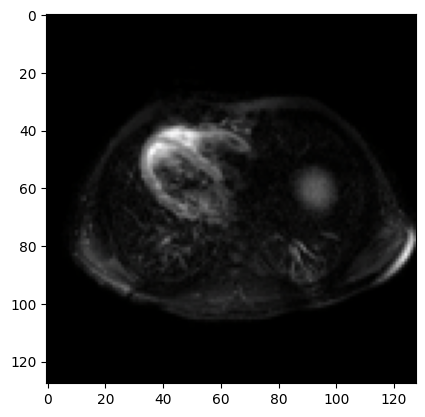

In [17]:
sample_index = 1
denormalized_img_array = (sample_batch["pixel_values"][sample_index].cpu().numpy() * np.array(visual_std_deviation)[:, None, None]) + np.array(visual_mean_values)[:, None, None]
denormalized_img_array = np.moveaxis(denormalized_img_array, 0, -1)
denormalized_img_array = (denormalized_img_array * 255).astype(np.uint8)

print("Question: ", text_processor_unit.decode(sample_batch["input_ids"][sample_index]))
print("Answer: ", text_processor_unit.decode(sample_batch["labels"][sample_index]))
plt.imshow(Image.fromarray(denormalized_img_array))

**Model Training Loop**

In [18]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the storage path in Drive
save_directory = "/content/drive/MyDrive/vqa_project_checkpoints"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

Mounted at /content/drive


In [20]:
from google.colab import drive
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt


best_val_loss = float('inf')
early_stop_patience = 3
epochs_without_improvement = 0
best_model_state = None

# Lists to record metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

vqa_base_model.train()
max_epochs = 15

for current_epoch in range(max_epochs):
    # TRAINING PHASE
    vqa_base_model.train()
    train_loss_total = 0
    train_match_count = 0
    train_sample_total = 0

    train_iterator = tqdm(train_loader_engine, desc=f"Epoch {current_epoch} [Train]")
    for current_batch in train_iterator:
        current_batch = {k: v.to(compute_device) for k, v in current_batch.items()}

        model_optimizer.zero_grad()
        outputs = vqa_base_model(**current_batch)

        loss = outputs.loss
        train_loss_total += loss.item()

        loss.backward()
        model_optimizer.step()

        # Training Accuracy Calculation
        with torch.no_grad():
            predictions = vqa_base_model.generate(
                pixel_values=current_batch['pixel_values'],
                input_ids=current_batch['input_ids'],
                attention_mask=current_batch['attention_mask'],
                max_length=32
            )
            decoded_preds = vqa_batch_processor.batch_decode(predictions, skip_special_tokens=True)
            decoded_labels = vqa_batch_processor.batch_decode(current_batch['labels'], skip_special_tokens=True)

            for pred_str, label_str in zip(decoded_preds, decoded_labels):
                if pred_str.strip().lower() == label_str.strip().lower():
                    train_match_count += 1
                train_sample_total += 1

    avg_train_loss = train_loss_total / len(train_loader_engine)
    train_acc_pct = (train_match_count / train_sample_total) * 100

    # VALIDATION PHASE
    vqa_base_model.eval()
    val_loss_total = 0
    val_match_count = 0
    val_sample_total = 0

    with torch.no_grad():
        val_iterator = tqdm(val_loader_engine, desc=f"Epoch {current_epoch} [Val]")
        for val_batch in val_iterator:
            val_batch = {k: v.to(compute_device) for k, v in val_batch.items()}
            val_outputs = vqa_base_model(**val_batch)
            val_loss_total += val_outputs.loss.item()

            # Validation Accuracy Calculation
            val_predictions = vqa_base_model.generate(
                pixel_values=val_batch['pixel_values'],
                input_ids=val_batch['input_ids'],
                attention_mask=val_batch['attention_mask'],
                max_length=32
            )
            decoded_val_preds = vqa_batch_processor.batch_decode(val_predictions, skip_special_tokens=True)
            decoded_val_labels = vqa_batch_processor.batch_decode(val_batch['labels'], skip_special_tokens=True)

            for p_str, l_str in zip(decoded_val_preds, decoded_val_labels):
                if p_str.strip().lower() == l_str.strip().lower():
                    val_match_count += 1
                val_sample_total += 1

    avg_val_loss = val_loss_total / len(val_loader_engine)
    val_acc_pct = (val_match_count / val_sample_total) * 100

    # Store metrics in lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc_pct)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc_pct)

    # 3. Print Summary
    print(f"\n[Epoch {current_epoch}] Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc_pct:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc_pct:.2f}%")

    #TRACK BEST MODEl
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_state = vqa_base_model.state_dict()
        print("New best model found! Storing state...")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).\n")

    if epochs_without_improvement >= early_stop_patience:
        print("Early stopping triggered.")
        # Optional: Restore best state
        vqa_base_model.load_state_dict(best_model_state)
        break

Epoch 0 [Val]: 100%|██████████| 17/17 [00:35<00:00,  2.08s/it]



[Epoch 0] Summary:
Train Loss: 0.2123 | Train Acc: 42.00%
Val Loss: 0.1782 | Val Acc: 35.16%
New best model found! Storing state...


Epoch 1 [Val]: 100%|██████████| 17/17 [00:37<00:00,  2.22s/it]



[Epoch 1] Summary:
Train Loss: 0.1355 | Train Acc: 45.84%
Val Loss: 0.1501 | Val Acc: 37.51%
New best model found! Storing state...


Epoch 2 [Val]: 100%|██████████| 17/17 [00:35<00:00,  2.07s/it]



[Epoch 2] Summary:
Train Loss: 0.1021 | Train Acc: 49.87%
Val Loss: 0.1162 | Val Acc: 40.43%
New best model found! Storing state...


Epoch 3 [Val]: 100%|██████████| 17/17 [00:35<00:00,  2.08s/it]



[Epoch 3] Summary:
Train Loss: 0.0850 | Train Acc: 55.42%
Val Loss: 0.1012 | Val Acc: 43.36%
New best model found! Storing state...


Epoch 4 [Val]: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]



[Epoch 4] Summary:
Train Loss: 0.0745 | Train Acc: 57.45%
Val Loss: 0.0912 | Val Acc: 43.64%
New best model found! Storing state...


Epoch 5 [Val]: 100%|██████████| 17/17 [00:34<00:00,  2.03s/it]



[Epoch 5] Summary:
Train Loss: 0.0693 | Train Acc: 58.02%
Val Loss: 0.0831 | Val Acc: 44.02%
New best model found! Storing state...


Epoch 6 [Val]: 100%|██████████| 17/17 [00:34<00:00,  2.05s/it]



[Epoch 6] Summary:
Train Loss: 0.0629 | Train Acc: 57.45%
Val Loss: 0.0882 | Val Acc: 44.39%
No improvement for 1 epoch(s).



Epoch 7 [Val]: 100%|██████████| 17/17 [00:33<00:00,  1.94s/it]



[Epoch 7] Summary:
Train Loss: 0.0611 | Train Acc: 54.30%
Val Loss: 0.0837 | Val Acc: 44.77%
No improvement for 2 epoch(s).



Epoch 8 [Val]: 100%|██████████| 17/17 [00:35<00:00,  2.11s/it]



[Epoch 8] Summary:
Train Loss: 0.0558 | Train Acc: 57.61%
Val Loss: 0.0745 | Val Acc: 47.50%
New best model found! Storing state...


Epoch 9 [Val]: 100%|██████████| 17/17 [00:34<00:00,  2.05s/it]



[Epoch 9] Summary:
Train Loss: 0.0536 | Train Acc: 56.96%
Val Loss: 0.0668 | Val Acc: 46.28%
New best model found! Storing state...


Epoch 10 [Val]: 100%|██████████| 17/17 [00:34<00:00,  2.05s/it]



[Epoch 10] Summary:
Train Loss: 0.0526 | Train Acc: 55.56%
Val Loss: 0.0648 | Val Acc: 46.56%
New best model found! Storing state...


Epoch 11 [Val]: 100%|██████████| 17/17 [00:33<00:00,  2.00s/it]



[Epoch 11] Summary:
Train Loss: 0.0506 | Train Acc: 56.15%
Val Loss: 0.0579 | Val Acc: 49.86%
New best model found! Storing state...


Epoch 12 [Val]: 100%|██████████| 17/17 [00:31<00:00,  1.88s/it]



[Epoch 12] Summary:
Train Loss: 0.0456 | Train Acc: 59.20%
Val Loss: 0.0525 | Val Acc: 51.27%
New best model found! Storing state...


Epoch 13 [Val]: 100%|██████████| 17/17 [00:32<00:00,  1.90s/it]



[Epoch 13] Summary:
Train Loss: 0.0407 | Train Acc: 64.61%
Val Loss: 0.0459 | Val Acc: 59.66%
New best model found! Storing state...


Epoch 14 [Val]: 100%|██████████| 17/17 [00:35<00:00,  2.08s/it]


[Epoch 14] Summary:
Train Loss: 0.0366 | Train Acc: 66.56%
Val Loss: 0.0478 | Val Acc: 57.78%
No improvement for 1 epoch(s).



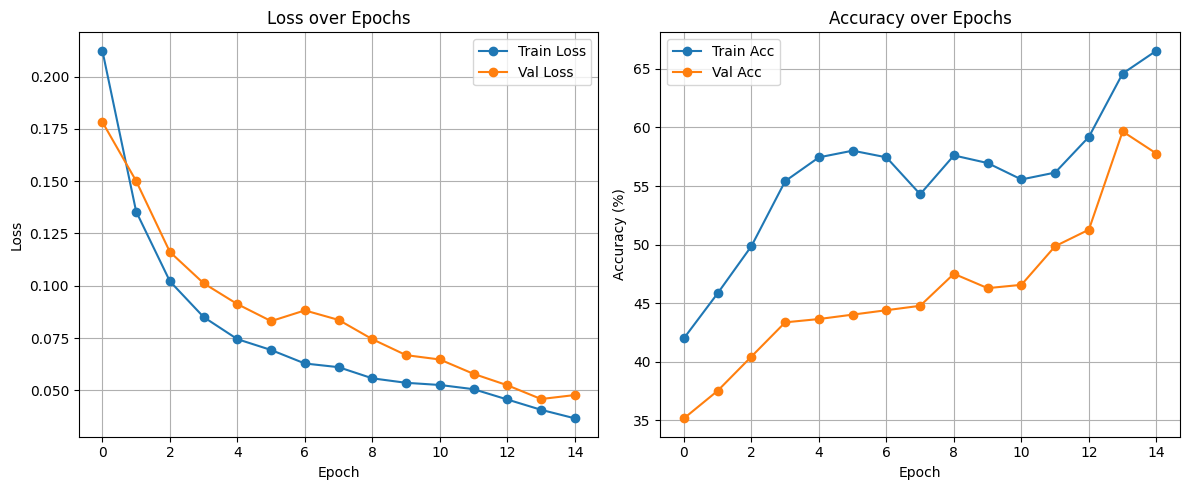

In [21]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc', marker='o')
plt.plot(val_accuracies, label='Val Acc', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Additional Way to Save the Model:
This is applied as usually during training GPU is limited and the performance is good enough to be saved so current state is saved

In [19]:
# Run when training loop is interrupted
if 'best_model_state' in locals() and best_model_state is not None:
    checkpoint_name = "vqa_SLAKE_best_model.pt"
    torch.save(best_model_state, os.path.join(save_directory, checkpoint_name))
    print(f"Successfully saved the best model found: {checkpoint_name}")
else:
    print("No best_model_state found in memory. ")

No best_model_state found in memory. 


In [23]:
checkpoint_path = "/content/drive/MyDrive/vqa_project_checkpoints/vqa_SLAKE_best_model.pt"

if os.path.exists(checkpoint_path):
    # Load the state dictionary
    trained_weights = torch.load(checkpoint_path, map_location=compute_device)

    # Apply weights to the model
    vqa_base_model.load_state_dict(trained_weights)

    # Set to evaluation mode
    vqa_base_model.eval()
    print(f"Successfully loaded model from: {checkpoint_path}")
else:
    print("Error: Checkpoint file not found. Check the Drive path.")

Successfully loaded model from: /content/drive/MyDrive/vqa_project_checkpoints/vqa_SLAKE_best_model.pt


VALIDATION TESTING

In [24]:
vqa_base_model.eval()

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [25]:
!pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a38b58b7a0420e516af60f905b93c7440c951bb24a5111ef8367f6085920e99d
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [28]:
import evaluate
from tqdm import tqdm
import torch

def calculate_detailed_metrics(vqa_model, vqa_loader, vqa_processor, compute_device):
    vqa_model.eval()

    # Load metrics
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")

    # Storage for categorization
    results = {
        'closed': {'preds': [], 'labels': []},
        'open': {'preds': [], 'labels': []}
    }

    # Overall counters
    overall_matches = 0
    overall_total = 0

    closed_triggers = {'yes', 'no'}
    accumulated_loss = 0

    with torch.no_grad():
        for batch in tqdm(vqa_loader, desc="Calculating Metrics"):
            batch = {k: v.to(compute_device) for k, v in batch.items()}
            outputs = vqa_model(**batch)
            accumulated_loss += outputs.loss.item()

            # Generate
            tokens = vqa_model.generate(
                pixel_values=batch['pixel_values'],
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                max_length=32
            )

            preds = vqa_processor.batch_decode(tokens, skip_special_tokens=True)
            labels = vqa_processor.batch_decode(batch['labels'], skip_special_tokens=True)

            for p, l in zip(preds, labels):
                p_clean = p.strip().lower()
                l_clean = l.strip().lower()

                Track Overall Accuracy
                if p_clean == l_clean:
                    overall_matches += 1
                overall_total += 1

                # Categorize based on label
                cat = 'closed' if l_clean in closed_triggers else 'open'
                results[cat]['preds'].append(p_clean)
                results[cat]['labels'].append(l_clean)

    # Calculation Logic
    def get_stats(cat_preds, cat_labels):
        if not cat_labels: return None

        # Exact Match Accuracy
        matches = sum(1 for p, l in zip(cat_preds, cat_labels) if p == l)
        acc = (matches / len(cat_labels)) * 100

        # BLEU & ROUGE
        bleu_score = bleu.compute(predictions=cat_preds, references=[[l] for l in cat_labels])['bleu'] * 100
        rouge_score = rouge.compute(predictions=cat_preds, references=cat_labels)['rougeL'] * 100

        return {"acc": acc, "bleu": bleu_score, "rouge": rouge_score, "count": len(cat_labels)}

    closed_stats = get_stats(results['closed']['preds'], results['closed']['labels'])
    open_stats = get_stats(results['open']['preds'], results['open']['labels'])

    # Overall Acc Calculation
    overall_accuracy = (overall_matches / overall_total * 100) if overall_total > 0 else 0

    # Print Results
    print("\n" + "="*40)
    print(f"DETAILED PERFORMANCE REPORT")
    print("="*40)

    #  Overall Accuracy
    print(f"OVERALL ACCURACY: {overall_accuracy:.2f}%")
    print("-" * 40)

    if closed_stats:
        print(f"CLOSED-ENDED (Total: {closed_stats['count']})")
        print(f" - Accuracy: {closed_stats['acc']:.2f}%")

    print("-" * 40)

    if open_stats:
        print(f"OPEN-ENDED (Total: {open_stats['count']})")
        print(f" - Accuracy: {open_stats['acc']:.2f}%")
        print(f" - BLEU:     {open_stats['bleu']:.2f}")
        print(f" - ROUGE-L:  {open_stats['rouge']:.2f}")

    print("="*40)
    return results

# Run the evaluation
metrics_results = calculate_detailed_metrics(vqa_base_model, val_loader_engine, vqa_batch_processor, compute_device)

Calculating Metrics: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]



DETAILED PERFORMANCE REPORT
OVERALL ACCURACY: 57.78%
----------------------------------------
CLOSED-ENDED (Total: 355)
 - Accuracy: 73.80%
----------------------------------------
OPEN-ENDED (Total: 706)
 - Accuracy: 49.72%
 - BLEU:     20.83
 - ROUGE-L:  55.91


------------------------------
Question:  where is the pulmonary nodule located in this image?
Predicted Answer:  right lung
Actual Answer:  lower left lung


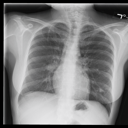

------------------------------
Question:  what organ system is pictured?
Predicted Answer:  chest
Actual Answer:  chest


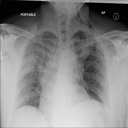

------------------------------
Question:  are there organs in the picture that can digest food?
Predicted Answer:  yes
Actual Answer:  no


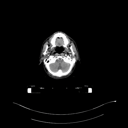

------------------------------
Question:  is this image taken via x - ray?
Predicted Answer:  yes
Actual Answer:  yes


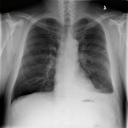

------------------------------
Question:  what is the scanning plane of this image?
Predicted Answer:  transverse plane
Actual Answer:  coronal plane


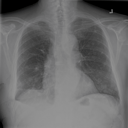

------------------------------
Question:  what is the largest organ in the picture?
Predicted Answer:  brain
Actual Answer:  brain


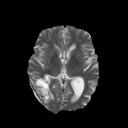

------------------------------
Question:  is / are there abnormalities in the patient ' s right lung?
Predicted Answer:  yes
Actual Answer:  yes


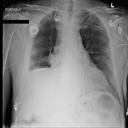

------------------------------
Question:  which part of the body does this image belong to?
Predicted Answer:  brain
Actual Answer:  abdomen


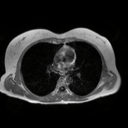

------------------------------
Question:  which organs / organ in the picture belong to the respiratory system?
Predicted Answer:  lung
Actual Answer:  lung


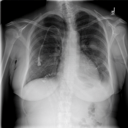

------------------------------
Question:  does the lung exist in this picture?
Predicted Answer:  no
Actual Answer:  yes


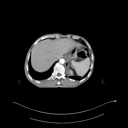

------------------------------
Question:  where is / are the abnormality located?
Predicted Answer:  lower left
Actual Answer:  right lung, left


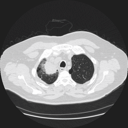

------------------------------
Question:  which is smaller in this image, esophagus or liver?
Predicted Answer:  liver
Actual Answer:  esophagus


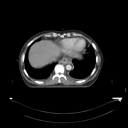

------------------------------
Question:  does the stomach appear in the image?
Predicted Answer:  no
Actual Answer:  no


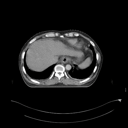

------------------------------
Question:  which is the biggest in this image, spleen, heart or liver?
Predicted Answer:  liver
Actual Answer:  liver


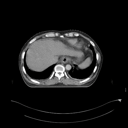

------------------------------
Question:  which organs appear in pairs?
Predicted Answer:  kidney
Actual Answer:  temporal lobe


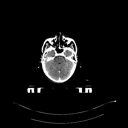

------------------------------
Question:  does the esophagus exist in this picture?
Predicted Answer:  no
Actual Answer:  yes


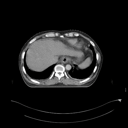

------------------------------
Question:  is the lung healthy?
Predicted Answer:  no
Actual Answer:  yes


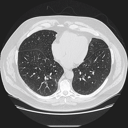

------------------------------
Question:  does the patient have any abnormalities?
Predicted Answer:  yes
Actual Answer:  yes


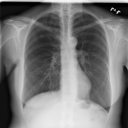

------------------------------
Question:  what color is the lung in the picture?
Predicted Answer:  gray
Actual Answer:  black


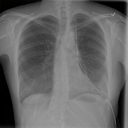

------------------------------
Question:  does this image look normal?
Predicted Answer:  no
Actual Answer:  no


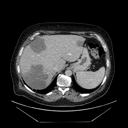

------------------------------
Question:  how many existing heart in this image?
Predicted Answer:  0
Actual Answer:  1


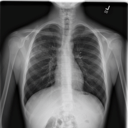

------------------------------
Question:  what is the largest organ in the picture?
Predicted Answer:  brain
Actual Answer:  brain


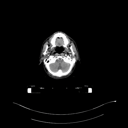

------------------------------
Question:  where is / are the abnormality located?
Predicted Answer:  lower right
Actual Answer:  left lung, right


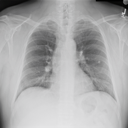

------------------------------
Question:  what is the largest organ in the picture?
Predicted Answer:  lung
Actual Answer:  lung


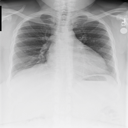

------------------------------
Question:  what is the function of the main organ in this picture?
Predicted Answer:  breathe
Actual Answer:  breathe


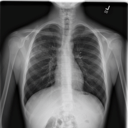

------------------------------
Question:  where is colon in this image?
Predicted Answer:  upper right
Actual Answer:  upper left


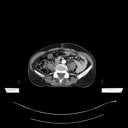

------------------------------
Question:  what is the mr weighting in this image?
Predicted Answer:  t2
Actual Answer:  t2


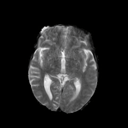

------------------------------
Question:  what modality is used to take this image?
Predicted Answer:  mri
Actual Answer:  ct


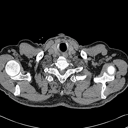

------------------------------
Question:  do the organs in the image exist in the head?
Predicted Answer:  yes
Actual Answer:  no


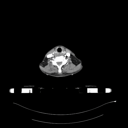

------------------------------
Question:  is the abnormality hyperdense or hypodense?
Predicted Answer:  hypodense
Actual Answer:  hyperdense


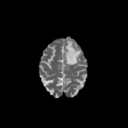

In [29]:
import random
import numpy as np
from PIL import Image

#Define the number of samples
num_samples = 30
#Pick random unique indices from the entire validation dataset
random_indices = random.sample(range(len(val_vqa_instance)), num_samples)

# Loop using the random indices
for loop_index in random_indices:
    current_data_point = val_vqa_instance[loop_index]

    print("-" * 30)
    print("Question: ", text_processor_unit.decode(current_data_point['input_ids'], skip_special_tokens=True))

    # Prepare sample for inference
    inference_sample = {key: val.unsqueeze(0).to(compute_device) for key, val in current_data_point.items()}

    # Model generation
    generated_prediction = vqa_base_model.generate(
        pixel_values=inference_sample['pixel_values'],
        input_ids=inference_sample['input_ids'],
        max_length=32
    )

    print("Predicted Answer: ", text_processor_unit.decode(generated_prediction[0], skip_special_tokens=True))
    print("Actual Answer: ", text_processor_unit.decode(inference_sample['labels'][0], skip_special_tokens=True))

    # Image denormalization for display
    visual_array = (inference_sample["pixel_values"][0].cpu().numpy() * np.array(visual_std_deviation)[:, None, None]) + np.array(visual_mean_values)[:, None, None]
    visual_array = (visual_array * 255).astype(np.uint8)
    visual_array = np.moveaxis(visual_array, 0, -1)

    display(Image.fromarray(visual_array))